 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Define-loss-functions" data-toc-modified-id="Define-loss-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define loss functions</a></span></li><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Define-models" data-toc-modified-id="Define-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define models</a></span></li><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Functions,-generators-and-data" data-toc-modified-id="Functions,-generators-and-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Functions, generators and data</a></span></li><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Training" data-toc-modified-id="Training-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training</a></span></li></ul></li><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#No-Data-Augmentation" data-toc-modified-id="No-Data-Augmentation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>No Data Augmentation</a></span></li><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Resize-the-bounding-box-instead-of-expanding-the-bounding-box-to-required-size" data-toc-modified-id="Resize-the-bounding-box-instead-of-expanding-the-bounding-box-to-required-size-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Resize the bounding box instead of expanding the bounding box to required size</a></span></li><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Including-computation-for-background-in-dice-coeff" data-toc-modified-id="Including-computation-for-background-in-dice-coeff-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Including computation for background in dice coeff</a></span></li><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Pseudo-labeling" data-toc-modified-id="Pseudo-labeling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Pseudo-labeling</a></span></li><li><span><a href="http://localhost:8889/notebooks/17-fullres-ang-09.ipynb#Worst-predictions" data-toc-modified-id="Worst-predictions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Worst predictions</a></span></li></ul></div>

# Load libraries

In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import math
import random
import gzip
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Define loss functions

In [3]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# Define models

In [4]:
def unet_down_one_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [5]:
def unet_max_pool(inputs):
    x = MaxPooling2D((2, 2), strides=(2, 2))(inputs)
    return x

In [6]:
def unet_up_one_block(up_input, down_input, num_filters):
    x = UpSampling2D((2,2))(up_input)
    x = concatenate([down_input, x], axis=3)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [7]:
def get_unet(input_shape = (256, 256, 3),
             num_classes = 1,
             initial_filters = 32,
             central_filters = 1024):
    
    num_filters = initial_filters
    
    out_list    = [Input(shape=input_shape)]
    down_interim_list = []
    
    while num_filters <= central_filters/2:
        x = unet_down_one_block(out_list[-1], num_filters)
        down_interim_list.append(x)
        num_filters = num_filters * 2
        y = unet_max_pool(x)
        out_list.append(y)
    
    x = unet_down_one_block(out_list[-1], num_filters)
    out_list.append(x)
    num_filters = int(num_filters / 2)
    
    while num_filters >= initial_filters:
        x = unet_up_one_block(out_list[-1], down_interim_list.pop(), num_filters)
        out_list.append(x)
        num_filters = int(num_filters / 2)
    
    classify = Conv2D(num_classes, (1,1), activation = 'sigmoid')(out_list[-1])
    
    model = Model(inputs=out_list[0], outputs=classify)
    
    return model

In [8]:
model = get_unet(input_shape=(896,1280,3), initial_filters=8)

In [9]:
model.load_weights('./weights/best_weights_1024_2.hdf5')

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 896, 1280, 3)  0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 896, 1280, 8)  224         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 896, 1280, 8)  32          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 896, 1280, 8)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

# Training

## Functions, generators and data

In [11]:
df_train = pd.read_csv('data/train_masks.csv')

In [12]:
train_bboxes = pickle.load(open('./train_bboxes_resized_m512_ang_09.pkl', 'rb'))

In [13]:
actual_bboxes = pickle.load(open('./train_bboxes_actuals.pkl', 'rb'))

In [14]:
ids_train = list(train_bboxes.keys())

In [15]:
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

In [16]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

In [17]:
def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask


In [18]:
def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


In [19]:
all_imgs  = {}
all_masks = {}
for id in ids_train:
    img  = cv2.imread('data/train/{}.jpg'.format(id))
    mask = cv2.imread('data/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
    all_imgs[id]  = img
    all_masks[id] = mask

In [20]:
def train_generator(train_batch_size):
    while True:
        this_ids_train_split = random.sample(ids_train_split, len(ids_train_split))
        for start in range(0, len(ids_train_split), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(ids_train_split))
            ids_train_batch = this_ids_train_split[start:end]
            for id in ids_train_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                
                this_bbox = train_bboxes[id]
                this_bbox = [math.floor(this_bbox[0]-25), math.ceil(this_bbox[1]+25),
                             math.floor(this_bbox[2]-20), math.ceil(this_bbox[3]+10)]
                
                x_size = this_bbox[1]-this_bbox[0]+1
                y_size = this_bbox[3]-this_bbox[2]+1
                
                x_diff=1280-x_size
                y_diff=896-y_size
                
                x_top=random.randint(0, min(x_diff, this_bbox[0]))
                x_bottom=min(x_diff-x_top, 1917-this_bbox[1])
                if (x_top+x_bottom) < x_diff:
                    if x_top==this_bbox[0]:
                        x_bottom = x_diff-x_top
                    else:
                        x_top = x_diff-x_bottom
                
                
                y_top=random.randint(0, min(y_diff, this_bbox[2]))
                y_bottom=min(y_diff-y_top, 1279-this_bbox[3])
                if (y_top+y_bottom) < y_diff:
                    if y_top==this_bbox[2]:
                        y_bottom = y_diff-y_top
                    else:
                        y_top = y_diff-y_bottom
                
                this_bbox[0] = this_bbox[0]-x_top
                this_bbox[1] = this_bbox[1]+x_bottom
                this_bbox[2] = this_bbox[2]-y_top
                this_bbox[3] = this_bbox[3]+y_bottom
                
                img  = img[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1),:]
                mask = mask[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1)]
                
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = randomHorizontalFlip(img, mask)
                
                mask = np.expand_dims(mask, axis=2)
                
                if img.shape[0]!=896 or img.shape[1]!=1280:
                    print(id)
                    print(x_top)
                    print(x_bottom)
                    print(y_top)
                    print(y_bottom)
                    print(x_diff)
                    print(y_diff)
                
                x_batch.append(img)
                y_batch.append(mask)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

In [21]:
def valid_generator(val_batch_size):
    while True:
        for start in range(0, len(ids_valid_split), val_batch_size):
            
            x_batch = []
            y_batch = []
            
            end = min(start + val_batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                
                this_bbox = list(actual_bboxes[id])
                
                x_size = this_bbox[1]-this_bbox[0]+1
                y_size = this_bbox[3]-this_bbox[2]+1
                
                x_diff=1280-x_size
                y_diff=896-y_size
                
                x_top=min(int(x_diff/2), this_bbox[0])
                x_bottom=min(x_diff-x_top, 1917-this_bbox[1])
                if (x_top+x_bottom) < x_diff:
                    if x_top==this_bbox[0]:
                        x_bottom = x_diff-x_top
                    else:
                        x_top = x_diff-x_bottom
                
                y_top=min(int(y_diff/2), this_bbox[2])
                y_bottom=min(y_diff-y_top, 1279-this_bbox[3])
                if (y_top+y_bottom) < y_diff:
                    if y_top==this_bbox[2]:
                        y_bottom = y_diff-y_top
                    else:
                        y_top = y_diff-y_bottom
                
                this_bbox[0] = this_bbox[0]-x_top
                this_bbox[1] = this_bbox[1]+x_bottom
                this_bbox[2] = this_bbox[2]-y_top
                this_bbox[3] = this_bbox[3]+y_bottom
                
                img  = img[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1),:]
                mask = mask[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1)]
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)  
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

## Training

In [22]:
train_batch_size = 6
val_batch_size   = 16

In [23]:
model.compile(optimizer=RMSprop(lr=0.00001), loss=bce_dice_loss, metrics=[dice_coeff])

In [24]:
model.evaluate_generator(valid_generator(val_batch_size), np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

[0.038488627411425114, 0.99135079979896545]

In [26]:
max_epochs = 50

In [27]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/full_res_ang_09.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/50
167s - loss: 0.0554 - dice_coeff: 0.9898 - val_loss: 0.0307 - val_dice_coeff: 0.9919
Epoch 2/50
156s - loss: 0.0252 - dice_coeff: 0.9928 - val_loss: 0.0266 - val_dice_coeff: 0.9924
Epoch 3/50
157s - loss: 0.0190 - dice_coeff: 0.9937 - val_loss: 0.0229 - val_dice_coeff: 0.9931
Epoch 4/50
157s - loss: 0.0195 - dice_coeff: 0.9936 - val_loss: 0.0200 - val_dice_coeff: 0.9936
Epoch 5/50
157s - loss: 0.0140 - dice_coeff: 0.9944 - val_loss: 0.0160 - val_dice_coeff: 0.9942
Epoch 6/50
157s - loss: 0.0139 - dice_coeff: 0.9945 - val_loss: 0.0150 - val_dice_coeff: 0.9943
Epoch 7/50
157s - loss: 0.0128 - dice_coeff: 0.9947 - val_loss: 0.0148 - val_dice_coeff: 0.9944
Epoch 8/50
157s - loss: 0.0127 - dice_coeff: 0.9948 - val_loss: 0.0144 - val_dice_coeff: 0.9945
Epoch 9/50
158s - loss: 0.0125 - dice_coeff: 0.9948 - val_loss: 0.0138 - val_dice_coeff: 0.9946
Epoch 10/50
157s - loss: 0.0121 - dice_coeff: 0.9949 - val_loss: 0.0135 - val_dice_coeff: 0.9946
Epoch 11/50
157s - loss: 0.0124 - dice_

KeyboardInterrupt: 

# No Data Augmentation

In [28]:
def train_generator(train_batch_size):
    while True:
        this_ids_train_split = random.sample(ids_train_split, len(ids_train_split))
        for start in range(0, len(ids_train_split), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(ids_train_split))
            ids_train_batch = this_ids_train_split[start:end]
            for id in ids_train_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                
                this_bbox = train_bboxes[id]
                this_bbox = [math.floor(this_bbox[0]-25), math.ceil(this_bbox[1]+25),
                             math.floor(this_bbox[2]-20), math.ceil(this_bbox[3]+10)]
                
                x_size = this_bbox[1]-this_bbox[0]+1
                y_size = this_bbox[3]-this_bbox[2]+1
                
                x_diff=1280-x_size
                y_diff=896-y_size
                
                x_top=min(int(x_diff/2), this_bbox[0])
                x_bottom=min(x_diff-x_top, 1917-this_bbox[1])
                if (x_top+x_bottom) < x_diff:
                    if x_top==this_bbox[0]:
                        x_bottom = x_diff-x_top
                    else:
                        x_top = x_diff-x_bottom
                
                
                y_top=min(int(y_diff/2), this_bbox[2])
                y_bottom=min(y_diff-y_top, 1279-this_bbox[3])
                if (y_top+y_bottom) < y_diff:
                    if y_top==this_bbox[2]:
                        y_bottom = y_diff-y_top
                    else:
                        y_top = y_diff-y_bottom
                
                this_bbox[0] = this_bbox[0]-x_top
                this_bbox[1] = this_bbox[1]+x_bottom
                this_bbox[2] = this_bbox[2]-y_top
                this_bbox[3] = this_bbox[3]+y_bottom
                
                img  = img[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1),:]
                mask = mask[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1)]
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

In [29]:
model.compile(optimizer=RMSprop(lr=0.00001), loss=bce_dice_loss, metrics=[dice_coeff])

In [30]:
model.load_weights('./weights/full_res_ang_09.hdf5')

In [31]:
model.evaluate_generator(valid_generator(val_batch_size), np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

[0.012845238903537393, 0.99489004909992218]

In [33]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/full_res_ang_09.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/50
158s - loss: 0.0104 - dice_coeff: 0.9956 - val_loss: 0.0132 - val_dice_coeff: 0.9948
Epoch 2/50
157s - loss: 0.0101 - dice_coeff: 0.9957 - val_loss: 0.0128 - val_dice_coeff: 0.9949
Epoch 3/50
157s - loss: 0.0100 - dice_coeff: 0.9957 - val_loss: 0.0133 - val_dice_coeff: 0.9948
Epoch 4/50
157s - loss: 0.0098 - dice_coeff: 0.9958 - val_loss: 0.0132 - val_dice_coeff: 0.9948
Epoch 5/50
157s - loss: 0.0096 - dice_coeff: 0.9959 - val_loss: 0.0130 - val_dice_coeff: 0.9949
Epoch 6/50
157s - loss: 0.0094 - dice_coeff: 0.9959 - val_loss: 0.0133 - val_dice_coeff: 0.9949
Epoch 7/50

Epoch 00006: reducing learning rate to 9.999999747378752e-07.
157s - loss: 0.0094 - dice_coeff: 0.9960 - val_loss: 0.0138 - val_dice_coeff: 0.9948
Epoch 8/50


KeyboardInterrupt: 

# Resize the bounding box instead of expanding the bounding box to required size 

In [46]:
def train_generator(train_batch_size):
    while True:
        this_ids_train_split = random.sample(ids_train_split, len(ids_train_split))
        for start in range(0, len(ids_train_split), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(ids_train_split))
            ids_train_batch = this_ids_train_split[start:end]
            for id in ids_train_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                
                this_bbox = train_bboxes[id]
                this_bbox = [math.floor(this_bbox[0]-25), math.ceil(this_bbox[1]+25),
                             math.floor(this_bbox[2]-20), math.ceil(this_bbox[3]+10)]
                
                img  = img[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1),:]
                mask = mask[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1)]
                
                img   = cv2.resize(img, (1280, 896), cv2.INTER_CUBIC)
                mask  = cv2.resize(mask, (1280, 896), cv2.INTER_CUBIC)
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

In [47]:
def valid_generator(val_batch_size):
    while True:
        for start in range(0, len(ids_valid_split), val_batch_size):
            
            x_batch = []
            y_batch = []
            
            end = min(start + val_batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                
                this_bbox = actual_bboxes[id]
                this_bbox = [math.floor(this_bbox[0]-25), math.ceil(this_bbox[1]+25),
                             math.floor(this_bbox[2]-20), math.ceil(this_bbox[3]+10)]
                
                img  = img[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1),:]
                mask = mask[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1)]
                
                img   = cv2.resize(img, (1280, 896), cv2.INTER_CUBIC)
                mask  = cv2.resize(mask, (1280, 896), cv2.INTER_CUBIC)
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)  
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

In [48]:
model.compile(optimizer=RMSprop(lr=0.00001), loss=bce_dice_loss, metrics=[dice_coeff])

In [49]:
model.load_weights('./weights/full_res_ang_09.hdf5')

In [50]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/full_res_ang_09_02.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/50
157s - loss: 2.9053 - dice_coeff: 0.8120 - val_loss: 2.4690 - val_dice_coeff: 0.8418
Epoch 2/50
156s - loss: 1.3298 - dice_coeff: 0.8283 - val_loss: 4.3768 - val_dice_coeff: 0.6887
Epoch 3/50
157s - loss: 0.7553 - dice_coeff: 0.8311 - val_loss: 2.2132 - val_dice_coeff: 0.7997
Epoch 4/50
157s - loss: 0.5018 - dice_coeff: 0.8559 - val_loss: 1.1598 - val_dice_coeff: 0.8484
Epoch 5/50
158s - loss: 0.3300 - dice_coeff: 0.8993 - val_loss: 0.5639 - val_dice_coeff: 0.8986
Epoch 6/50
158s - loss: 0.1774 - dice_coeff: 0.9489 - val_loss: 0.4256 - val_dice_coeff: 0.9138
Epoch 7/50
158s - loss: 0.1119 - dice_coeff: 0.9676 - val_loss: 0.2967 - val_dice_coeff: 0.9328
Epoch 8/50
157s - loss: 0.0843 - dice_coeff: 0.9753 - val_loss: 0.1937 - val_dice_coeff: 0.9551
Epoch 9/50
158s - loss: 0.0696 - dice_coeff: 0.9795 - val_loss: 0.1614 - val_dice_coeff: 0.9667
Epoch 10/50
158s - loss: 0.0591 - dice_coeff: 0.9821 - val_loss: 0.1087 - val_dice_coeff: 0.9771
Epoch 11/50
158s - loss: 0.0553 - dice_

# Including computation for background in dice coeff

In [38]:
def dice_coeff_background(y_true, y_pred):
    smooth = 1.
    y_true_f = 1 - K.flatten(y_true)
    y_pred_f = 1 - K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss_background(y_true, y_pred):
    loss = 1 - dice_coeff_background(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred) + dice_loss_background(y_true, y_pred)
    return loss

In [39]:
model.compile(optimizer=RMSprop(lr=0.00001), loss=bce_dice_loss2, metrics=[dice_coeff, dice_coeff_background])

In [40]:
model.evaluate_generator(valid_generator(val_batch_size), np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

[0.015648298896849155, 0.99472890794277191, 0.99752886593341827]

In [41]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/full_res_ang_09_02.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/50
158s - loss: 0.0128 - dice_coeff: 0.9955 - dice_coeff_background: 0.9978 - val_loss: 0.0151 - val_dice_coeff: 0.9949 - val_dice_coeff_background: 0.9976
Epoch 2/50
156s - loss: 0.0125 - dice_coeff: 0.9956 - dice_coeff_background: 0.9979 - val_loss: 0.0150 - val_dice_coeff: 0.9949 - val_dice_coeff_background: 0.9976
Epoch 3/50
157s - loss: 0.0123 - dice_coeff: 0.9957 - dice_coeff_background: 0.9979 - val_loss: 0.0153 - val_dice_coeff: 0.9949 - val_dice_coeff_background: 0.9976
Epoch 4/50
157s - loss: 0.0122 - dice_coeff: 0.9958 - dice_coeff_background: 0.9980 - val_loss: 0.0152 - val_dice_coeff: 0.9950 - val_dice_coeff_background: 0.9977
Epoch 5/50
157s - loss: 0.0125 - dice_coeff: 0.9957 - dice_coeff_background: 0.9979 - val_loss: 0.0155 - val_dice_coeff: 0.9950 - val_dice_coeff_background: 0.9976
Epoch 6/50
157s - loss: 0.0121 - dice_coeff: 0.9958 - dice_coeff_background: 0.9980 - val_loss: 0.0153 - val_dice_coeff: 0.9950 - val_dice_coeff_background: 0.9977
Epoch 7/50

Epoc

KeyboardInterrupt: 

# Pseudo-labeling

In [42]:
def find_bounding_boxes(tmp):
    
    axis_0_sum = np.sum(tmp, axis=0)
    axis_1_sum = np.sum(tmp, axis=1)
    
    y_min = np.nonzero(axis_1_sum)[0][0]
    y_max = np.nonzero(axis_1_sum)[0][-1]
    
    x_min = np.nonzero(axis_0_sum)[0][0]
    x_max = np.nonzero(axis_0_sum)[0][-1]
    
    return (x_min, x_max, y_min, y_max)

In [43]:
from os import listdir
ids_test = [x.split('.')[0] for x in listdir('data/preds09/')]

In [44]:
def train_generator(train_batch_size):
    while True:
        this_ids_train_split = random.sample(ids_train_split, len(ids_train_split))
        for start in range(0, len(ids_train_split), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(ids_train_split))
            ids_train_batch = this_ids_train_split[start:end]
            for id in ids_train_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                
                this_bbox = train_bboxes[id]
                this_bbox = [math.floor(this_bbox[0]-25), math.ceil(this_bbox[1]+25),
                             math.floor(this_bbox[2]-20), math.ceil(this_bbox[3]+10)]
                
                x_size = this_bbox[1]-this_bbox[0]+1
                y_size = this_bbox[3]-this_bbox[2]+1
                
                x_diff=1280-x_size
                y_diff=896-y_size
                
                x_top=random.randint(0, min(x_diff, this_bbox[0]))
                x_bottom=min(x_diff-x_top, 1917-this_bbox[1])
                if (x_top+x_bottom) < x_diff:
                    if x_top==this_bbox[0]:
                        x_bottom = x_diff-x_top
                    else:
                        x_top = x_diff-x_bottom
                
                
                y_top=random.randint(0, min(y_diff, this_bbox[2]))
                y_bottom=min(y_diff-y_top, 1279-this_bbox[3])
                if (y_top+y_bottom) < y_diff:
                    if y_top==this_bbox[2]:
                        y_bottom = y_diff-y_top
                    else:
                        y_top = y_diff-y_bottom
                
                this_bbox[0] = this_bbox[0]-x_top
                this_bbox[1] = this_bbox[1]+x_bottom
                this_bbox[2] = this_bbox[2]-y_top
                this_bbox[3] = this_bbox[3]+y_bottom
                
                img  = img[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1),:]
                mask = mask[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1)]
                
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

In [45]:
def test_generator(test_batch_size):
    while True:
        this_ids_test = random.sample(ids_test, len(ids_test))
        for start in range(0, len(ids_test), test_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + test_batch_size, len(ids_test))
            ids_test_batch = this_ids_test[start:end]
            for id in ids_test_batch:
                img  = cv2.imread('data/test/{}.jpg'.format(id))
                mask = np.load('./data/preds09/' + id + '.npy')*255
                
                this_bbox = list(find_bounding_boxes(mask))
                
                x_size = this_bbox[1]-this_bbox[0]+1
                y_size = this_bbox[3]-this_bbox[2]+1
                
                x_diff=1280-x_size
                y_diff=896-y_size
                
                x_top=random.randint(0, min(x_diff, this_bbox[0]))
                x_bottom=min(x_diff-x_top, 1917-this_bbox[1])
                if (x_top+x_bottom) < x_diff:
                    if x_top==this_bbox[0]:
                        x_bottom = x_diff-x_top
                    else:
                        x_top = x_diff-x_bottom
                
                
                y_top=random.randint(0, min(y_diff, this_bbox[2]))
                y_bottom=min(y_diff-y_top, 1279-this_bbox[3])
                if (y_top+y_bottom) < y_diff:
                    if y_top==this_bbox[2]:
                        y_bottom = y_diff-y_top
                    else:
                        y_top = y_diff-y_bottom
                
                this_bbox[0] = this_bbox[0]-x_top
                this_bbox[1] = this_bbox[1]+x_bottom
                this_bbox[2] = this_bbox[2]-y_top
                this_bbox[3] = this_bbox[3]+y_bottom
                
                img  = img[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1),:]
                mask = mask[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1)]
                
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


In [46]:
def pseudo_lab_gen():
    train_gen = train_generator(4)
    test_gen  = test_generator(2)
    while True:
        train_stuff = next(train_gen)
        if train_stuff[0].shape[0] != 4:
            train_stuff = next(train_gen)
        
        test_stuff  = next(test_gen)
        if test_stuff[0].shape[0] != 2:
            test_stuff  = next(test_gen)
        yield np.concatenate((train_stuff[0], test_stuff[0]), axis=0), np.concatenate((train_stuff[1], test_stuff[1]), axis=0)

In [47]:
model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])

In [48]:
model.load_weights('./weights/full_res_ang_09.hdf5')

In [49]:
max_epochs=20

In [50]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/full_res_ang_09.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

history = model.fit_generator(generator=pseudo_lab_gen(),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(4)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/20
235s - loss: 0.0129 - dice_coeff: 0.9950 - val_loss: 0.0188 - val_dice_coeff: 0.9935
Epoch 2/20
233s - loss: 0.0108 - dice_coeff: 0.9955 - val_loss: 0.0158 - val_dice_coeff: 0.9943
Epoch 3/20
233s - loss: 0.0107 - dice_coeff: 0.9956 - val_loss: 0.0147 - val_dice_coeff: 0.9947
Epoch 4/20
233s - loss: 0.0113 - dice_coeff: 0.9954 - val_loss: 0.0633 - val_dice_coeff: 0.9817
Epoch 5/20
233s - loss: 0.0100 - dice_coeff: 0.9958 - val_loss: 0.0187 - val_dice_coeff: 0.9940
Epoch 6/20
233s - loss: 0.0099 - dice_coeff: 0.9959 - val_loss: 0.0131 - val_dice_coeff: 0.9950
Epoch 7/20
233s - loss: 0.0095 - dice_coeff: 0.9960 - val_loss: 0.0131 - val_dice_coeff: 0.9950
Epoch 8/20


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/sainath/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sainath/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sainath/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-46-6c6b9b90cbd2>", line 9, in pseudo_lab_gen
    test_stuff  = next(test_gen)
  File "<ipython-input-45-a90ada5acd64>", line 30, in test_generator
    y_top=random.randint(0, min(y_diff, this_bbox[2]))
  File "/home/sainath/anaconda3/lib/python3.6/random.py", line 220, in randint
    return self.randrange(a, b+1)
  File "/home/sainath/anaconda3/lib/python3.6/random.py", line 198, in randrange
    raise ValueError("empty range for randrange() (%d,%d, %d)" % (istart, istop, width))
ValueError: empty range for ra

StopIteration: 

In [51]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/full_res_ang_09.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

history = model.fit_generator(generator=pseudo_lab_gen(),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(4)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/20
232s - loss: 0.0099 - dice_coeff: 0.9959 - val_loss: 0.0124 - val_dice_coeff: 0.9953
Epoch 2/20
232s - loss: 0.0090 - dice_coeff: 0.9962 - val_loss: 0.0126 - val_dice_coeff: 0.9954
Epoch 3/20
233s - loss: 0.0132 - dice_coeff: 0.9957 - val_loss: 0.0122 - val_dice_coeff: 0.9954
Epoch 4/20
233s - loss: 0.0087 - dice_coeff: 0.9963 - val_loss: 0.0132 - val_dice_coeff: 0.9951
Epoch 5/20
233s - loss: 0.0094 - dice_coeff: 0.9961 - val_loss: 0.0122 - val_dice_coeff: 0.9951
Epoch 6/20
233s - loss: 0.0128 - dice_coeff: 0.9955 - val_loss: 0.0161 - val_dice_coeff: 0.9947
Epoch 7/20
233s - loss: 0.0087 - dice_coeff: 0.9963 - val_loss: 0.0120 - val_dice_coeff: 0.9955
Epoch 8/20
233s - loss: 0.0087 - dice_coeff: 0.9963 - val_loss: 0.0117 - val_dice_coeff: 0.9953
Epoch 9/20
233s - loss: 0.0089 - dice_coeff: 0.9962 - val_loss: 0.0132 - val_dice_coeff: 0.9951
Epoch 10/20
233s - loss: 0.0084 - dice_coeff: 0.9964 - val_loss: 0.0127 - val_dice_coeff: 0.9952
Epoch 11/20
233s - loss: 0.0086 - dice_

Exception in thread Thread-27:
Traceback (most recent call last):
  File "/home/sainath/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sainath/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sainath/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-46-6c6b9b90cbd2>", line 9, in pseudo_lab_gen
    test_stuff  = next(test_gen)
  File "<ipython-input-45-a90ada5acd64>", line 30, in test_generator
    y_top=random.randint(0, min(y_diff, this_bbox[2]))
  File "/home/sainath/anaconda3/lib/python3.6/random.py", line 220, in randint
    return self.randrange(a, b+1)
  File "/home/sainath/anaconda3/lib/python3.6/random.py", line 198, in randrange
    raise ValueError("empty range for randrange() (%d,%d, %d)" % (istart, istop, width))
ValueError: empty range for ra

StopIteration: 

In [52]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/full_res_ang_09.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

history = model.fit_generator(generator=pseudo_lab_gen(),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(4)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/20
229s - loss: 0.0075 - dice_coeff: 0.9968 - val_loss: 0.0118 - val_dice_coeff: 0.9956
Epoch 2/20
231s - loss: 0.0076 - dice_coeff: 0.9967 - val_loss: 0.0119 - val_dice_coeff: 0.9956
Epoch 3/20
232s - loss: 0.0074 - dice_coeff: 0.9968 - val_loss: 0.0119 - val_dice_coeff: 0.9957
Epoch 4/20
233s - loss: 0.0073 - dice_coeff: 0.9968 - val_loss: 0.0120 - val_dice_coeff: 0.9957
Epoch 5/20
233s - loss: 0.0074 - dice_coeff: 0.9968 - val_loss: 0.0119 - val_dice_coeff: 0.9957
Epoch 6/20

Epoch 00005: reducing learning rate to 9.999999747378752e-07.
233s - loss: 0.0074 - dice_coeff: 0.9968 - val_loss: 0.0121 - val_dice_coeff: 0.9957
Epoch 7/20
233s - loss: 0.0073 - dice_coeff: 0.9969 - val_loss: 0.0120 - val_dice_coeff: 0.9957
Epoch 8/20
233s - loss: 0.0073 - dice_coeff: 0.9969 - val_loss: 0.0120 - val_dice_coeff: 0.9957
Epoch 9/20
232s - loss: 0.0071 - dice_coeff: 0.9969 - val_loss: 0.0120 - val_dice_coeff: 0.9957
Epoch 10/20

Epoch 00009: reducing learning rate to 9.999999974752428e-08

# Worst predictions

In [25]:
model.load_weights('./weights/full_res_ang_09.hdf5')

In [32]:
actual_img=[]
actual_mask=[]
predicted_mask=[]
for start in range(0, len(ids_train), val_batch_size):
    x_batch = []
    
    end = min(start + val_batch_size, len(ids_train))
    ids_batch = ids_train[start:end]
    
    for id in ids_batch:
        img = all_imgs[id]
        mask = all_masks[id]
        
        this_bbox = train_bboxes[id]
        this_bbox = [math.floor(this_bbox[0]-25), math.ceil(this_bbox[1]+25),
                     math.floor(this_bbox[2]-20), math.ceil(this_bbox[3]+10)]
        
        x_size = this_bbox[1]-this_bbox[0]+1
        y_size = this_bbox[3]-this_bbox[2]+1
        
        x_diff=1280-x_size
        y_diff=896-y_size
        
        x_top=min(int(x_diff/2), this_bbox[0])
        x_bottom=min(x_diff-x_top, 1917-this_bbox[1])
        if (x_top+x_bottom) < x_diff:
            if x_top==this_bbox[0]:
                x_bottom = x_diff-x_top
            else:
                x_top = x_diff-x_bottom
        
        y_top=min(int(y_diff/2), this_bbox[2])
        y_bottom=min(y_diff-y_top, 1279-this_bbox[3])
        if (y_top+y_bottom) < y_diff:
            if y_top==this_bbox[2]:
                y_bottom = y_diff-y_top
            else:
                y_top = y_diff-y_bottom
        
        this_bbox[0] = this_bbox[0]-x_top
        this_bbox[1] = this_bbox[1]+x_bottom
        this_bbox[2] = this_bbox[2]-y_top
        this_bbox[3] = this_bbox[3]+y_bottom
        
        img  = img[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1),:]
        mask = mask[this_bbox[2]:(this_bbox[3]+1), this_bbox[0]:(this_bbox[1]+1)]/255
        
        x_batch.append(img)
        actual_img.append(img)
        actual_mask.append(mask)
    
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis=3)
    
    for i in range(len(ids_batch)):
        tmp = np.copy(preds[i,:,:])
        tmp = (tmp > 0.5).astype(int)
        predicted_mask.append(tmp)

In [33]:
def dice_coeff_numpy(y_true, y_pred):
    return 2*np.sum(np.multiply(y_true, y_pred))/(np.sum(y_pred) + np.sum(y_true))

In [36]:
dice_coeff_vals=[]
for i in range(len(ids_train)):
    dice_coeff_vals.append(dice_coeff_numpy(actual_mask[i], predicted_mask[i]))

In [43]:
df = pd.DataFrame({'slno': range(len(dice_coeff_vals)), 'coeff': dice_coeff_vals})

In [47]:
df = df.sort_values('coeff')

In [64]:
df.head(10)

,coeff,slno
295,0.991489,295
196,0.993070,196
176,0.993288,176
75,0.993350,75
82,0.993761,82
185,0.994176,185
298,0.994349,298
104,0.994362,104
184,0.994589,184
168,0.995000,168


In [58]:
def plot_diff(i):
    img  = actual_img[i]
    pred = predicted_mask[i]
    act  = actual_mask[i]
    pred_minus_act = pred-act
    
    plt.figure(figsize=(15, 15))
    plt.subplot(2,2,1)
    plt.imshow(pred, cmap="PiYG")
    plt.subplot(2,2,2)
    plt.imshow(act, cmap="PiYG")
    plt.subplot(2,2,3)
    plt.imshow(img)
    plt.subplot(2,2,4)
    plt.imshow(pred_minus_act, cmap="PiYG")
    plt.show()

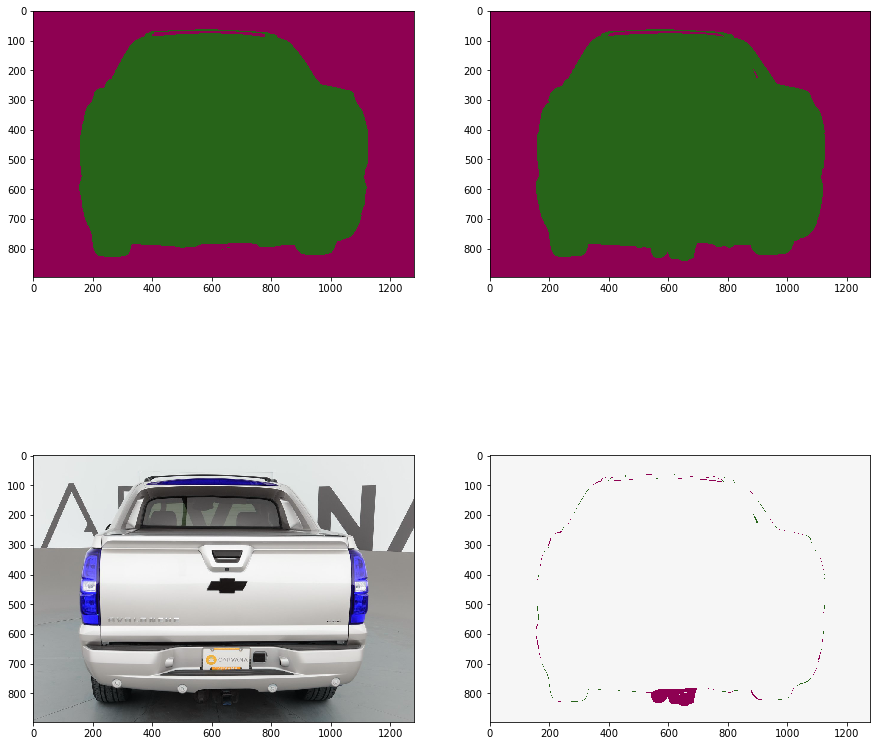

In [59]:
plot_diff(295);

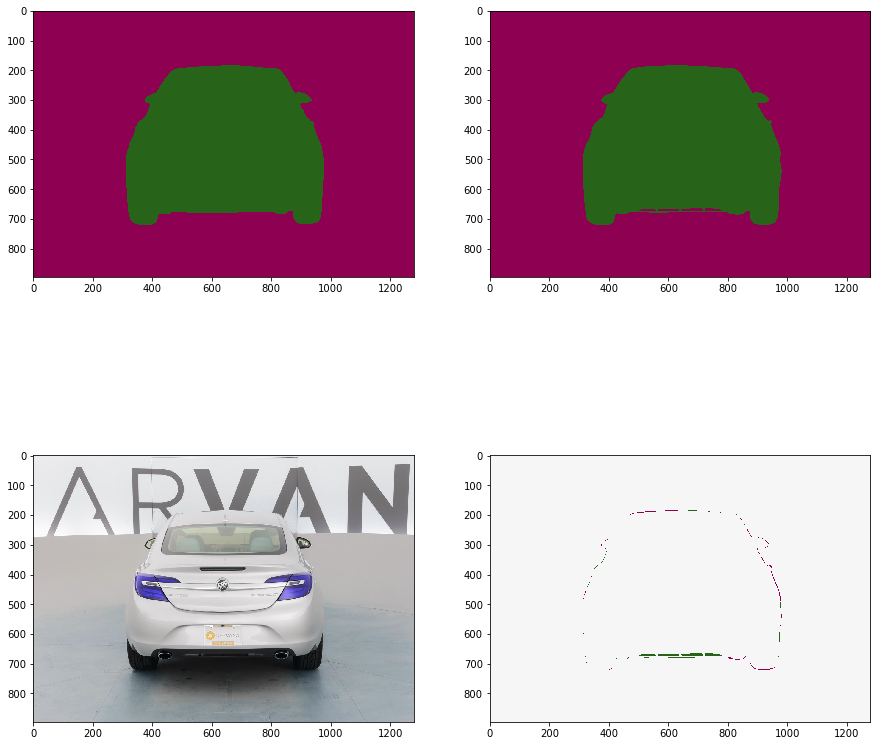

In [60]:
plot_diff(196);

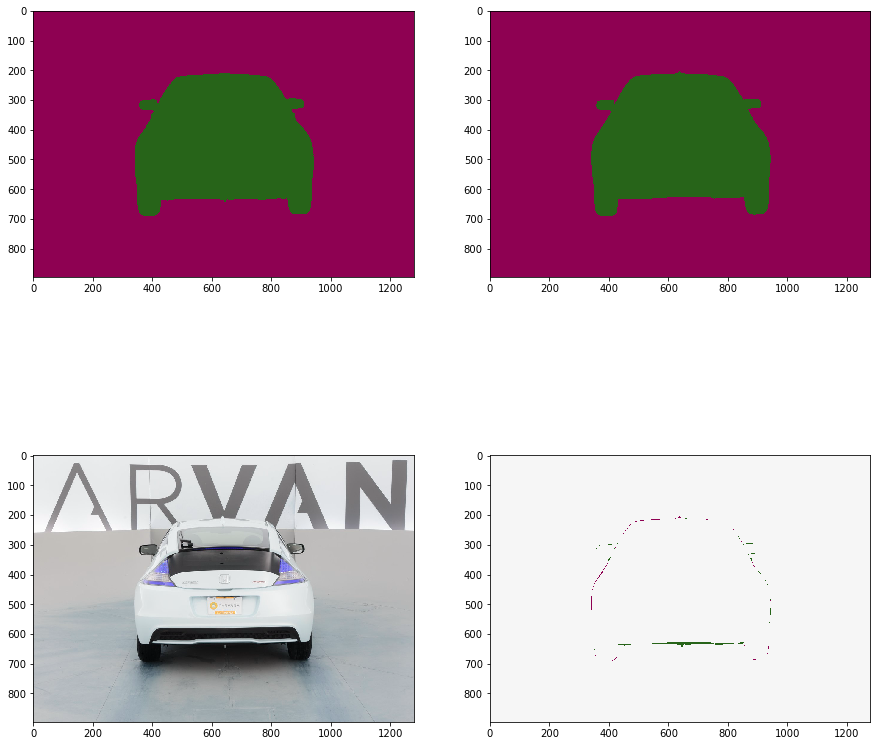

In [61]:
plot_diff(176);

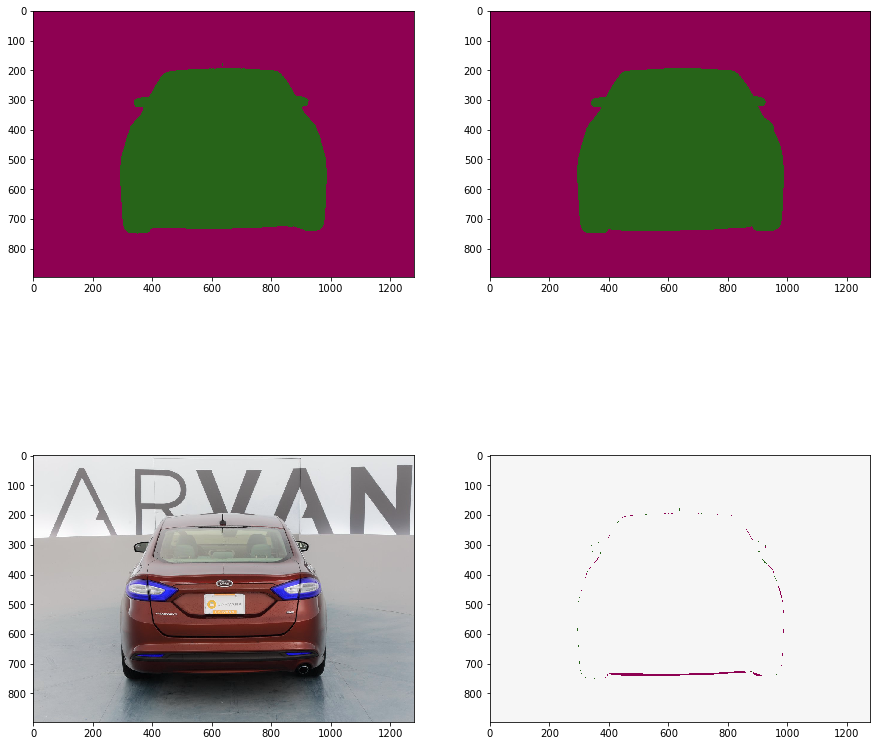

In [62]:
plot_diff(75);

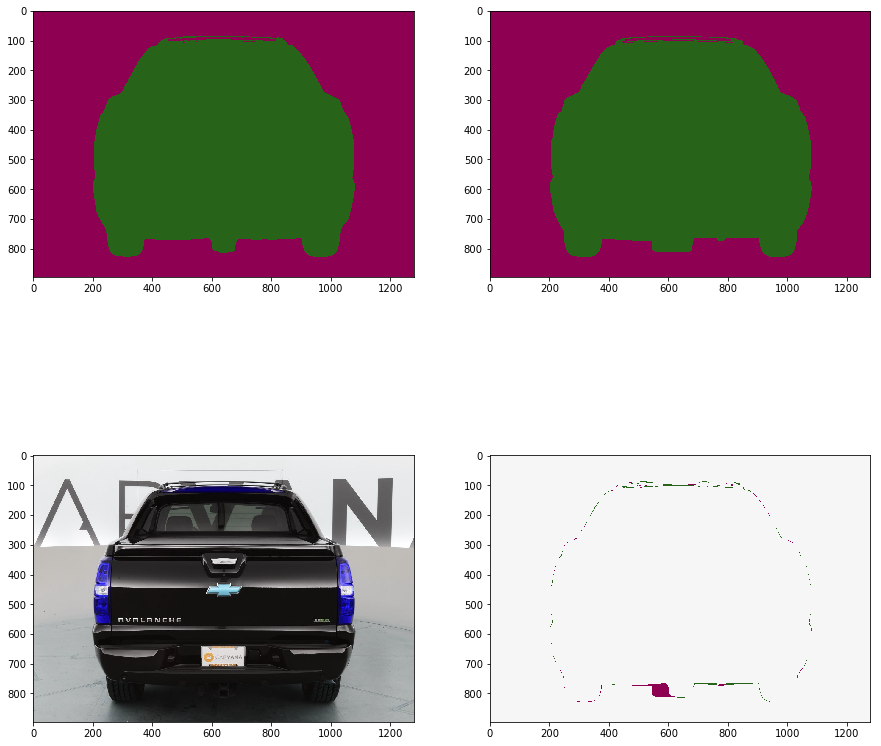

In [63]:
plot_diff(82);

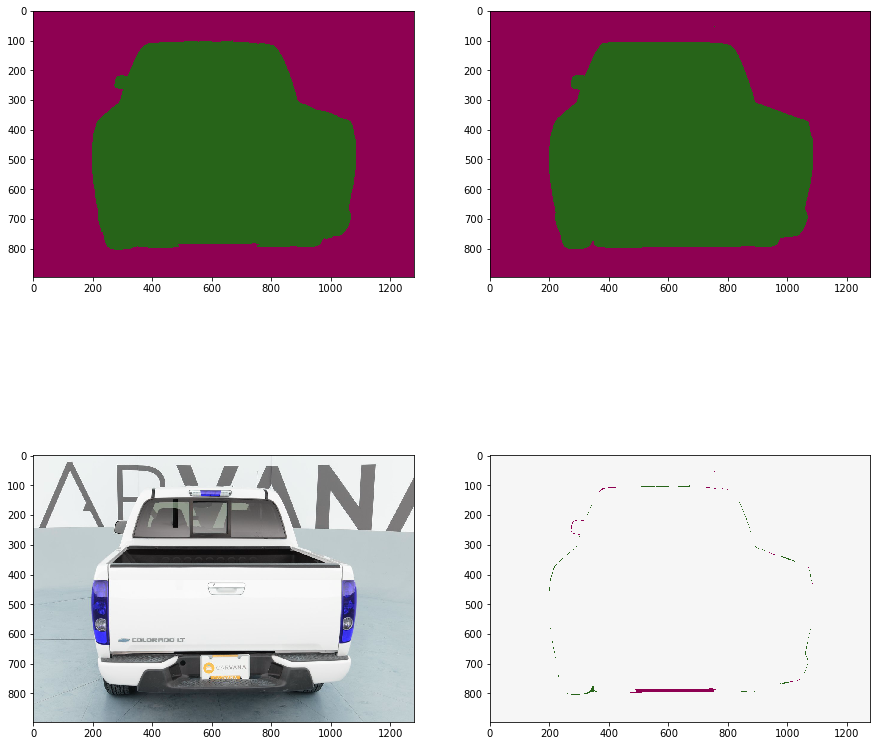

In [65]:
plot_diff(185);

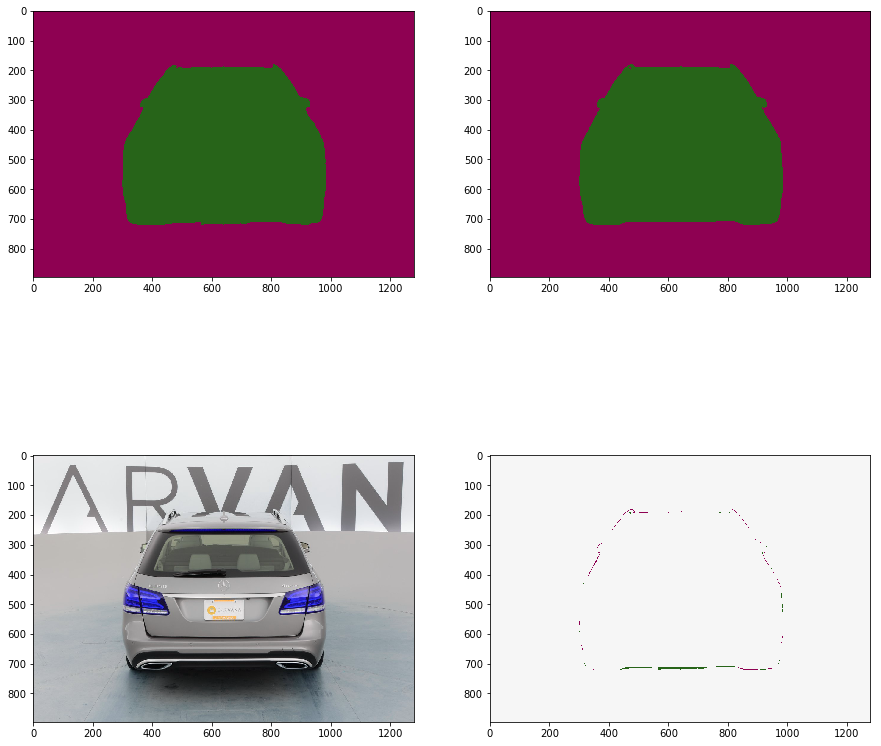

In [66]:
plot_diff(298);

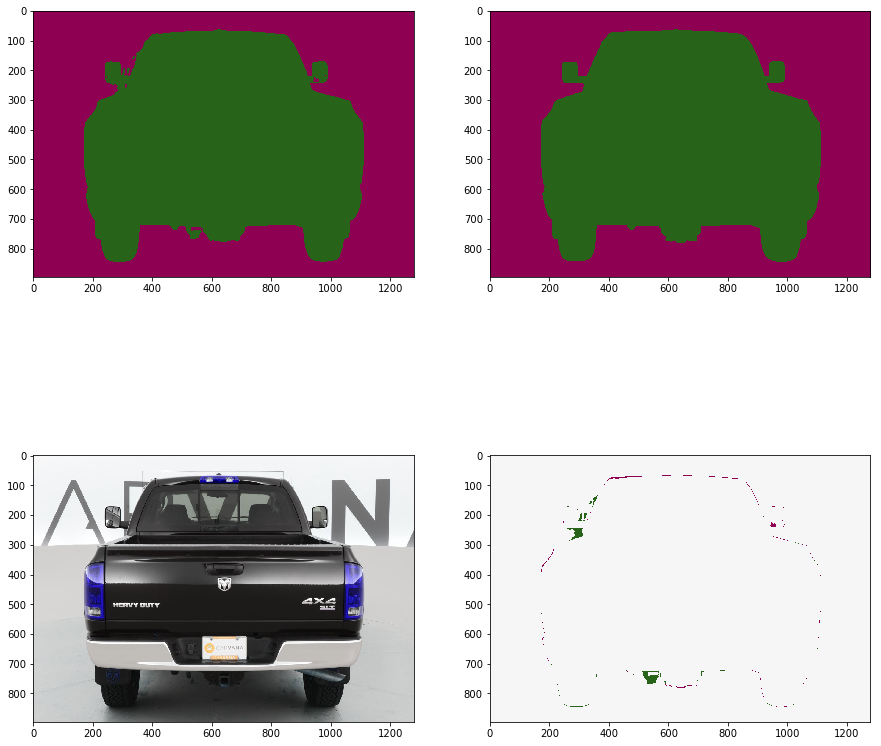

In [67]:
plot_diff(104);

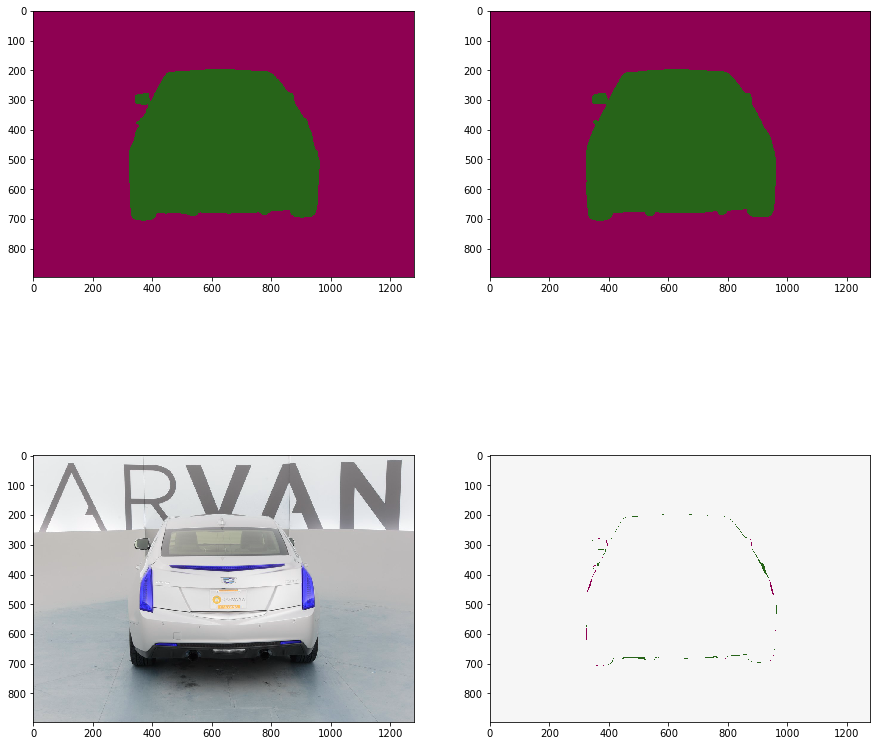

In [68]:
plot_diff(184);

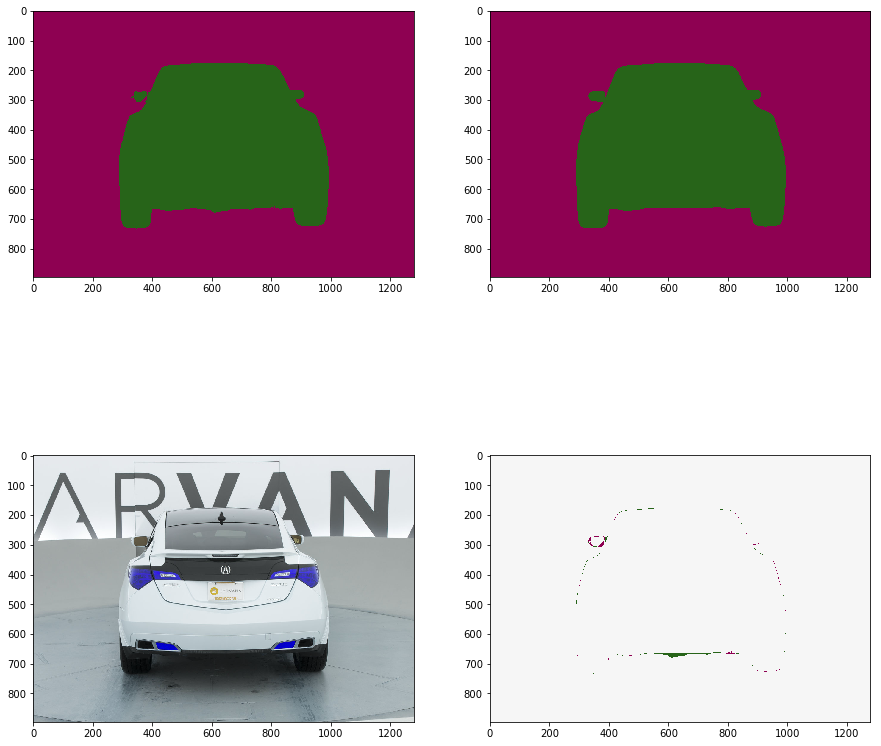

In [69]:
plot_diff(168);